In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [50]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = self.sc.optimal_omegad(self.A)[0]*2*np.pi 
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)

    def noise_check(self):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



Numerically evaluatd power: 2.5087668092931724e-09
Numerically evaluated variance: 2.5087383577273116e-09
Analytically evaluated power: 2.363955656882057e-09
PSD fit: power law v.s frequency = -1.0006, fitted intercept = -9.9869, fitted S0 = 1.015153e-05 Φ₀


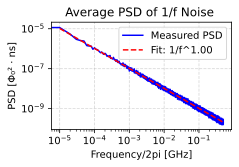

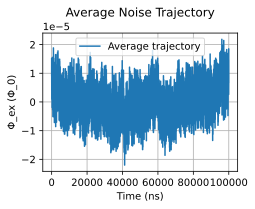

In [51]:
A = 5e-3*2*np.pi
initial_state = []
t_max = 100000
num_realizations = 100
S0 = 1e-5
sample_rate = 1        # per ns
sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
sim.noise_check()

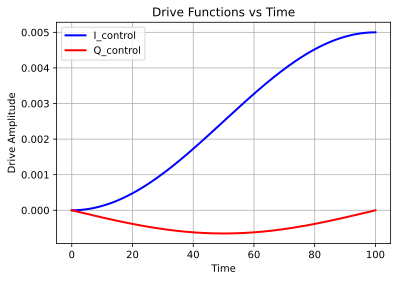

In [65]:
ramp_time = 100
T = 5*ramp_time
sds, sop, H_control, H0 = sim.operators()
freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
I_control = sim.I_control(ramp_time, T, A)
Q_control = sim.Q_control(freq, ramp_time, T, A)
sim_time = ramp_time
time_points = np.linspace(0, sim_time, 1000)
def plot_drive_func():
    """
    Plot the drive functions (I_control and Q_control) versus time_points.
    """
    # Calculate the drive function values at the desired time points.
    I_vals = I_control(time_points)
    Q_vals = Q_control(time_points)
    
    # If matplotlib hasn't been imported in an earlier cell, this import will work here.
    import matplotlib.pyplot as plt  
    plt.figure(figsize=(6, 4))
    plt.plot(time_points, I_vals/2/np.pi, label='I_control', color='blue', lw=2)
    plt.plot(time_points, Q_vals/2/np.pi, label='Q_control', color='red', lw=2)
    plt.xlabel('Time')
    plt.ylabel('Drive Amplitude')
    plt.title('Drive Functions vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function to display the figure.
plot_drive_func()


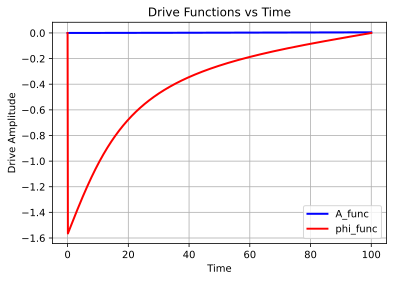

In [66]:
A_func = sim.A_function(freq, ramp_time, T, A)
phi_func = sim.phi_function(freq, ramp_time, T, A)
sim_time = T
time_points = np.linspace(0, ramp_time, 1000)
def plot_drive_func():
    """
    Plot the drive functions (I_control and Q_control) versus time_points.
    """
    # Calculate the drive function values at the desired time points.
    A_vals = A_func(time_points)
    phi_vals = phi_func(time_points)
    
    # If matplotlib hasn't been imported in an earlier cell, this import will work here.
    import matplotlib.pyplot as plt  
    plt.figure(figsize=(6, 4))
    plt.plot(time_points, A_vals/2/np.pi, label='A_func', color='blue', lw=2)
    plt.plot(time_points, phi_vals, label='phi_func', color='red', lw=2)
    plt.xlabel('Time')
    plt.ylabel('Drive Amplitude')
    plt.title('Drive Functions vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function to display the figure.
plot_drive_func()


In [67]:
# Define parameter ranges
gamma = 1/(2e4)
sds, sop, H_control, H0 = sim.operators()
floquet_states,sigmax,sigmas = sim.kick_and_sigmax(ramp_time)
get_projector = sim.get_projector
floquet_ground = floquet_states[:,0]
projectors = get_projector(floquet_states)

In [68]:
initial_state = qt.basis(6,0)
H = [H0, [H_control,  lambda t, args: A_func(t)*np.cos(sim.optimal_omega*t+phi_func(t))]]
opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
result = qt.sesolve(H, initial_state, time_points, options=opts)
state_t = result.states[-1]
avg_value0 = qt.expect(projectors[0], state_t) 

In [58]:
avg_value0

0.9999973369613435

In [81]:
drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))
opts = {'nsteps': t_max, 'atol': 1e-10, 'rtol': 1e-10}

avg_values = []
for idx in [0, 1]:
    H = [H0, [H_control, drive_term]]
    result = qt.sesolve(H, qt.basis(6, idx), time_points, options=opts)
    avg_values.append(qt.expect(projectors[idx], result.states[-1]))

avg_value0, avg_value1 = avg_values

In [ ]:
drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))
opts = {'nsteps': t_max, 'atol': 1e-11, 'rtol': 1e-11}
i=0
avg_values = []
L = np.sqrt(gamma) * qt.Qobj(sop)
c_ops = [L]
idx = 0
traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
result = qt.mesolve(H, qt.basis(6, idx), time_points, c_ops, options=opts)
avg_values.append(qt.expect(projectors[idx], result.states[-1]))

avg_value0, avg_value1 = avg_values

In [96]:
(np.sqrt(avg_value0) + np.sqrt(avg_value1))**2/4

np.float64(0.9999671575608097)

In [ ]:
L = np.sqrt(gamma) * qt.Qobj(sop)
c_ops = [L]
def simulate_trajectory(i):
    traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
    H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0], [H_control,  lambda t, args: drive_func(t)]]
    opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
    avg_values = np.zeros(len(time_points))
    state_t = result.states[-1]
    avg_values[j] = qt.expect(P00, state_t) 
    return avg_values

# result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

array([ 0.68680755-1.50374391e-04j,  0.69084813-1.49396914e-04j,
        0.00406896+1.66528933e-01j,  0.13855997+6.29538433e-02j,
        0.00802965+2.92558362e-05j, -0.00290359+6.38754195e-03j])